# Illustrational Data Analysis

## Table of Contents
1. Creating for Fourier and Order analysis
2. Creating for Envelope Order analysis

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
%load_ext autoreload

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os,os.path
from scipy import signal
from scipy.stats import kurtosis, skew

ROOT_PATH = os.path.abspath("..").split("data_processing")[0]
module_paths = []
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/data_processing/")))
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/hybrid_analysis_process_functions/")))
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/utils/")))
for module_path in module_paths:
    if module_path not in sys.path:
        print("appended")
        sys.path.append(module_path)
%autoreload 2
import functions as f
import wt_data, ff_transform, explore_fft_time_data, envelope, build_dataset, load_raw_signals, envelope, envelope_emd,plotting_methods
import resample_signals, filter_signals, plotting_methods,filters,correlation_coeff


appended
appended
appended
ROOT /Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src
/Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src
ROOT /Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src
ROOT /Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src
ROOT /Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src


## 1. Creating for Fourier and Order analysis

In [4]:
folder_path = f'../../plots/envelope_dummy_data/'

In [5]:
fs = 10000   # sampling frequency
f0 = 9       # slow shaft
f1 = 25      # fast shaft
f_gmf  = 225 # gear mesh frequency
f_gmf2 = 450 # 2nd harmonic gear mesh frequency

# Creating the signals
t = np.arange(0, 1, 1/fs)
low_shaft    = 0.89 * np.sin(2*np.pi*f0*t)
high_shaft   = 1.21 * np.sin(2*np.pi*f1*t)
gear_mesh    = 0.36 * np.sin(2*np.pi*f_gmf*t)
gear_mesh_2  = 0.31 * np.sin(2*np.pi*f_gmf2*t)
white_nosie  = np.random.rand(len(t))/3
# Combining the signals
shafts       = low_shaft+high_shaft
shaft_gear   = shafts+gear_mesh
shaft_gear2  = shaft_gear+gear_mesh_2
complete_sig = shaft_gear2 +white_nosie



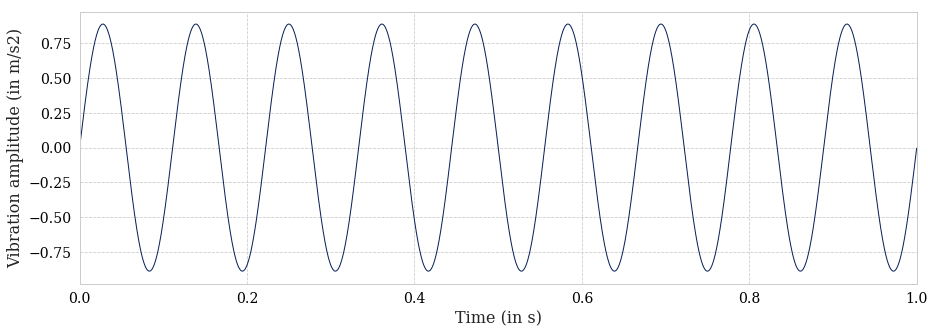

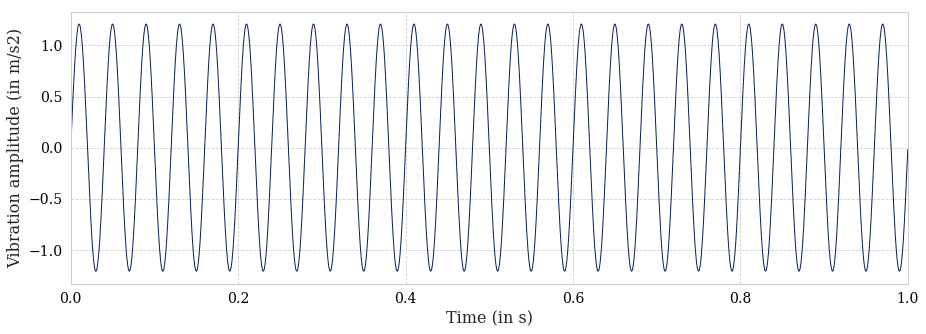

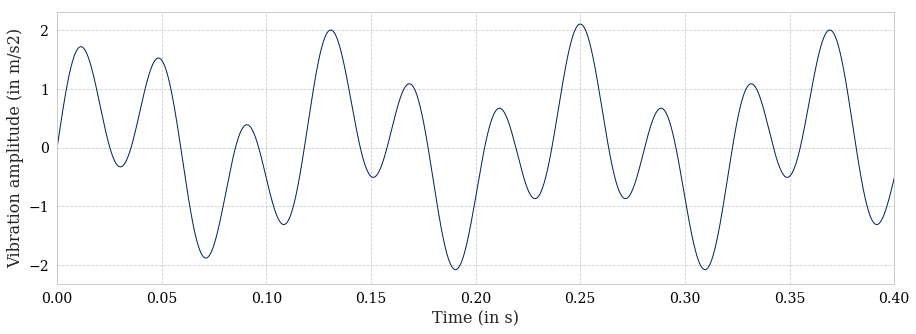

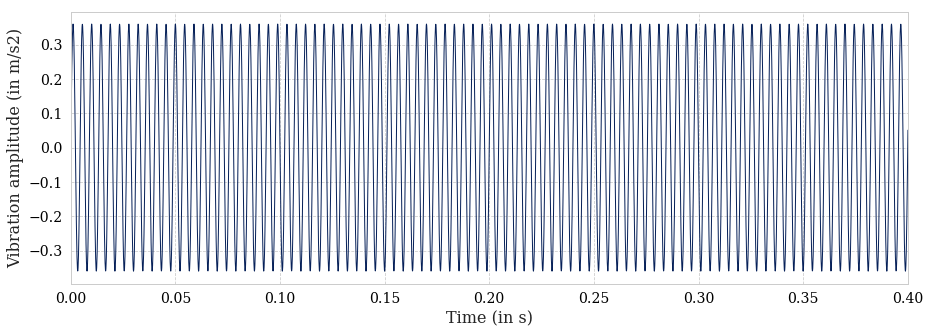

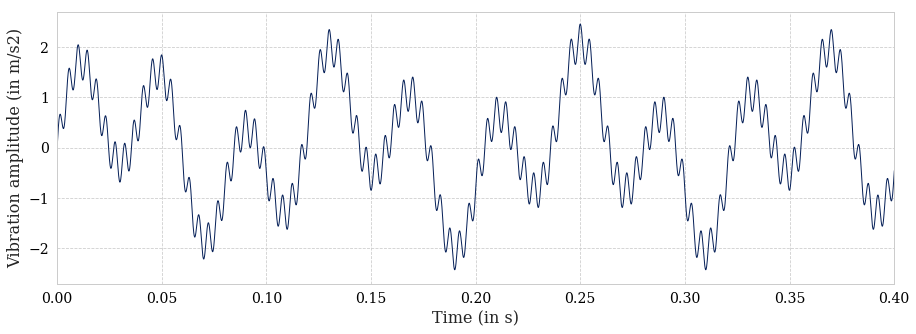

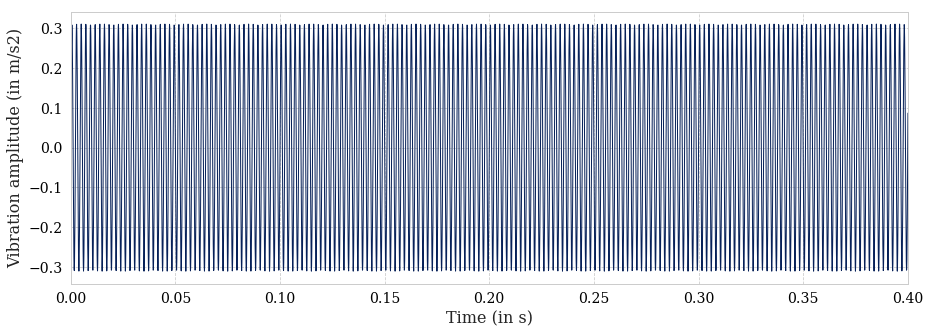

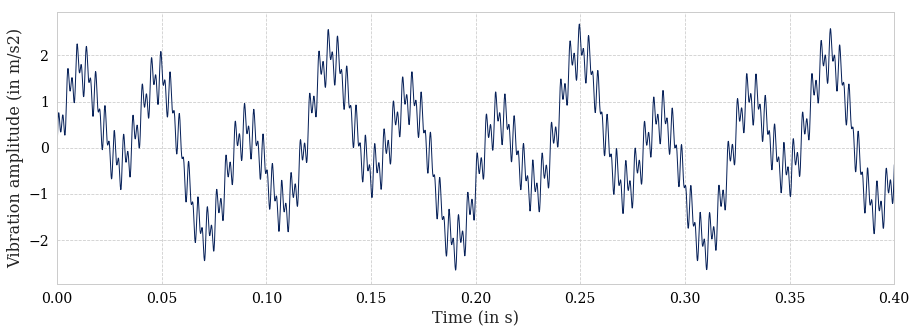

hello


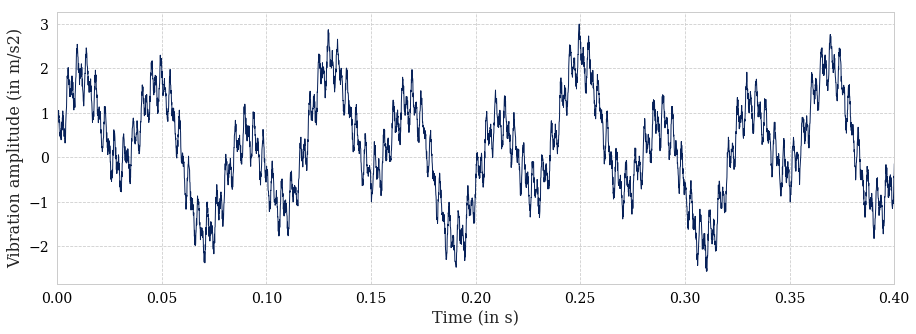

In [6]:
#Plotting shaft only
plotting_methods.plot_signal(t, low_shaft, linewidth=1)
plotting_methods.plot_signal(t, high_shaft, linewidth=1)
plotting_methods.plot_signal(t, shafts, linewidth=1, x_max=0.4)

# Plot shaft with one gear mesh
plotting_methods.plot_signal(t, gear_mesh, linewidth=1, x_max=0.4)
plotting_methods.plot_signal(t, shaft_gear, linewidth=1, x_max=0.4)

# Plot shaft with both gear mesh
plotting_methods.plot_signal(t, gear_mesh_2, linewidth=1, x_max=0.4)
plotting_methods.plot_signal(t, shaft_gear2, linewidth=1, x_max=0.4)

print('hello')
#Plot signal with noise
plotting_methods.plot_signal(t, complete_sig, linewidth=1, x_max=0.4)

# Plot FFT of sigal with noise
fft_signal, freq = plotting_methods.plot_fft(t, complete_sig, x_max=500)

In [7]:
def plotable_fft(fft):
    N = fft.shape[0]
    y = np.abs(fft)[:N // 2] * 1 / N  # Normalized
    return y

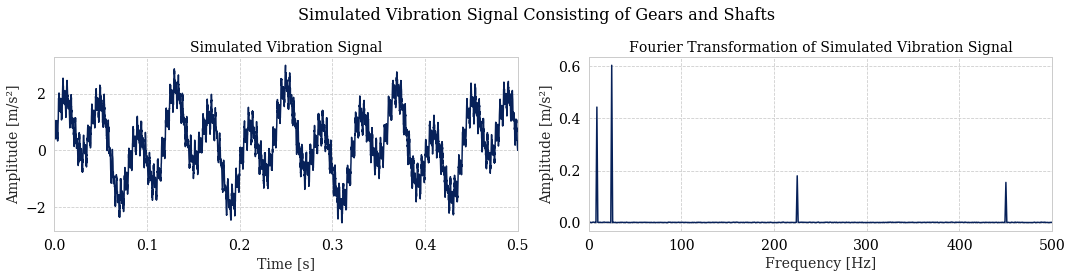

In [8]:
# Create one plot with signal and fft

fig, ax = plt.subplots(1, 2,figsize=(15,3.5))
heading = 'Simulated Vibration Signal Consisting of Gears and Shafts'
my_suptitle = fig.suptitle(heading,fontsize=16, y=1.09)

# Row 1
ax[0].plot(t, complete_sig)
ax[0].set_title(f"Simulated Vibration Signal")
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Amplitude [m/s\u00b2]")
ax[0].set_xlim(0, 0.5)

ax[1].plot(freq, plotable_fft(fft_signal))
ax[1].set_title(f"Fourier Transformation of Simulated Vibration Signal")
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Amplitude [m/s\u00b2]")
ax[1].set_xlim(0, 500)

plt.tight_layout()
plt.savefig(f'{folder_path}simulated_gear_signal.png', dpi=300, bbox_extra_artists=[my_suptitle], bbox_inches='tight')
plt.show()

## 2. Creating for Envelope Order analysis

In [9]:
fs = 10000  # sampling frequency
f0 = 25     # the inner race rotates at 25 cycles per second (The outer race is stationary)
n = 8       # number of balls in bearing
d = 0.02    # diameter of each ball
p = 0.12    # pitch diameter: distance from center of ball on one side to center of opposing ball

t = np.arange(0, 1, 1/fs)
# MatLab description of z signal
#z = [1, 0.5, 0.2, 0.1, 0.05] * np.sin(2 * np.pi * f0 * [1,2,3,4,5] * t)/5

# Python description of z signal
y = np.sin(2*np.pi*f0 * np.dot(np.array([[1,2,3,4,5]]).T, np.array([t])) ) /5
z = np.dot([1, 0.5, 0.2, 0.1, 0.05], y)

In [10]:
# BPFO defect signal (Ball Pass Frequency Outer race):

ca = 0 # contact angle
bpfo = n*f0/2*(1- d/p * np.cos(ca))
bpfo

83.33333333333333

In [11]:
# Model each impact as a 3 kHz sinusoid windowed by a flat top window
f_impact = 3000
t_impact = np.arange(0, 0.005 - 1/fs, 1/fs)
t_impact.shape
x_impact = np.sin(2* np.pi * f_impact * t_impact) * signal.flattop(len(t_impact)) / 10

x_comb = np.zeros(len(t))
index = int(round(fs/bpfo))
x_comb[0:-1:index] = 1

x = np.convolve(x_comb, x_impact, 'same')/3

In [12]:
# Add white Gaussioan noise to the signal
healthy_data = z
bpfo_fault = z+x

healtyh_data_noise = healthy_data + np.random.rand(len(z))/30
bpfo_fault_noise = bpfo_fault + np.random.rand(len(z))/30

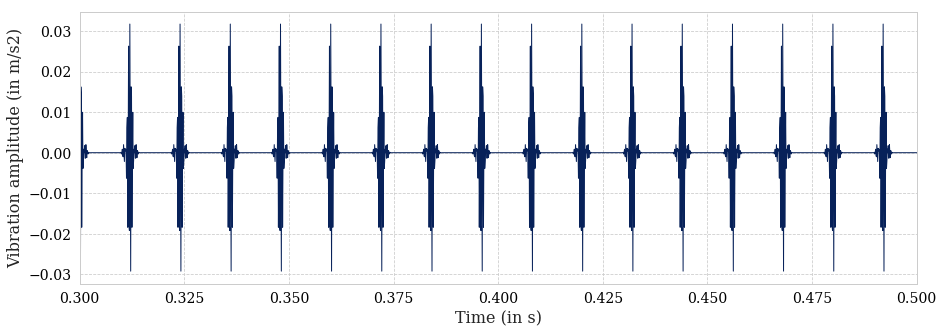

In [13]:
plotting_methods.plot_signal(t, x, x_min=0.3, x_max=0.5, linewidth=1)


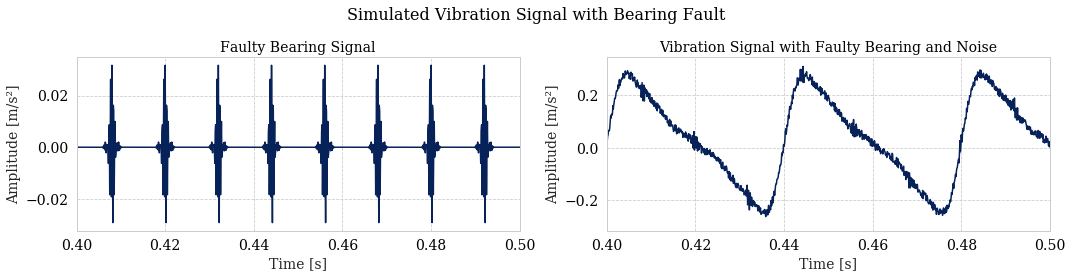

In [17]:
fig, ax = plt.subplots(1, 2,figsize=(15,3.5))
heading = 'Simulated Vibration Signal with Bearing Fault'
my_suptitle = fig.suptitle(heading,fontsize=16, y=1.09)

# Row 1
ax[0].plot(t, x)
ax[0].set_title(f"Faulty Bearing Signal")
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Amplitude [m/s\u00b2]")
ax[0].set_xlim(0.4, 0.5)

ax[1].plot(t, bpfo_fault_noise)
ax[1].set_xlabel("Time [s]")
ax[1].set_title(f"Vibration Signal with Faulty Bearing and Noise")
ax[1].set_ylabel("Amplitude [m/s\u00b2]")
ax[1].set_xlim(0.4, 0.5)

plt.tight_layout()
plt.savefig(f'{folder_path}bpfo_dummy_signal.png', dpi=300, bbox_extra_artists=[my_suptitle], bbox_inches='tight')
plt.show()

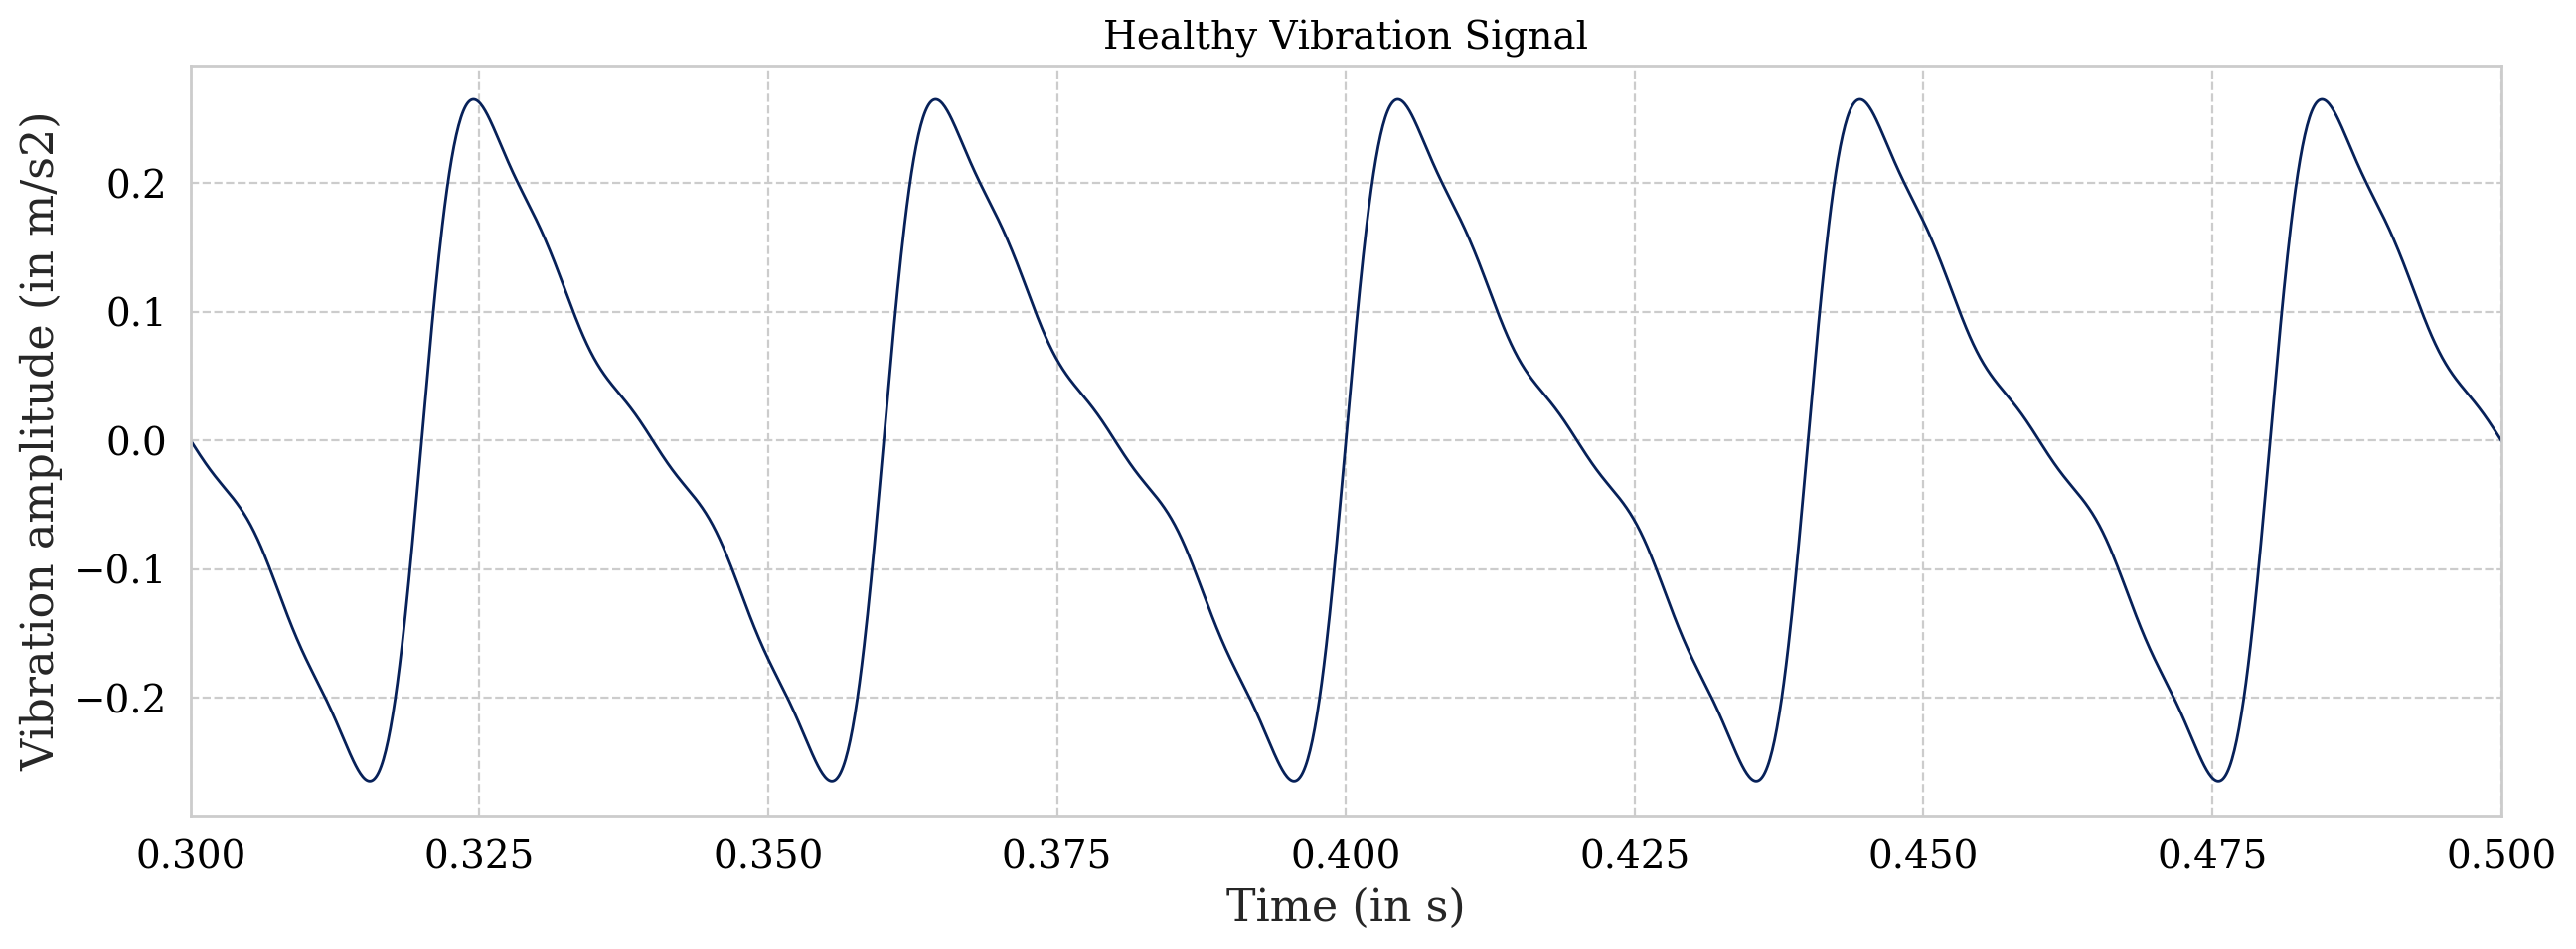

In [30]:
file_name = f'{folder_path}simple_signal'
title = 'Healthy Vibration Signal'
plotting_methods.plot_signal(t, healthy_data, x_min=0.3, x_max=0.5, linewidth=1, name=title, save_path=file_name)


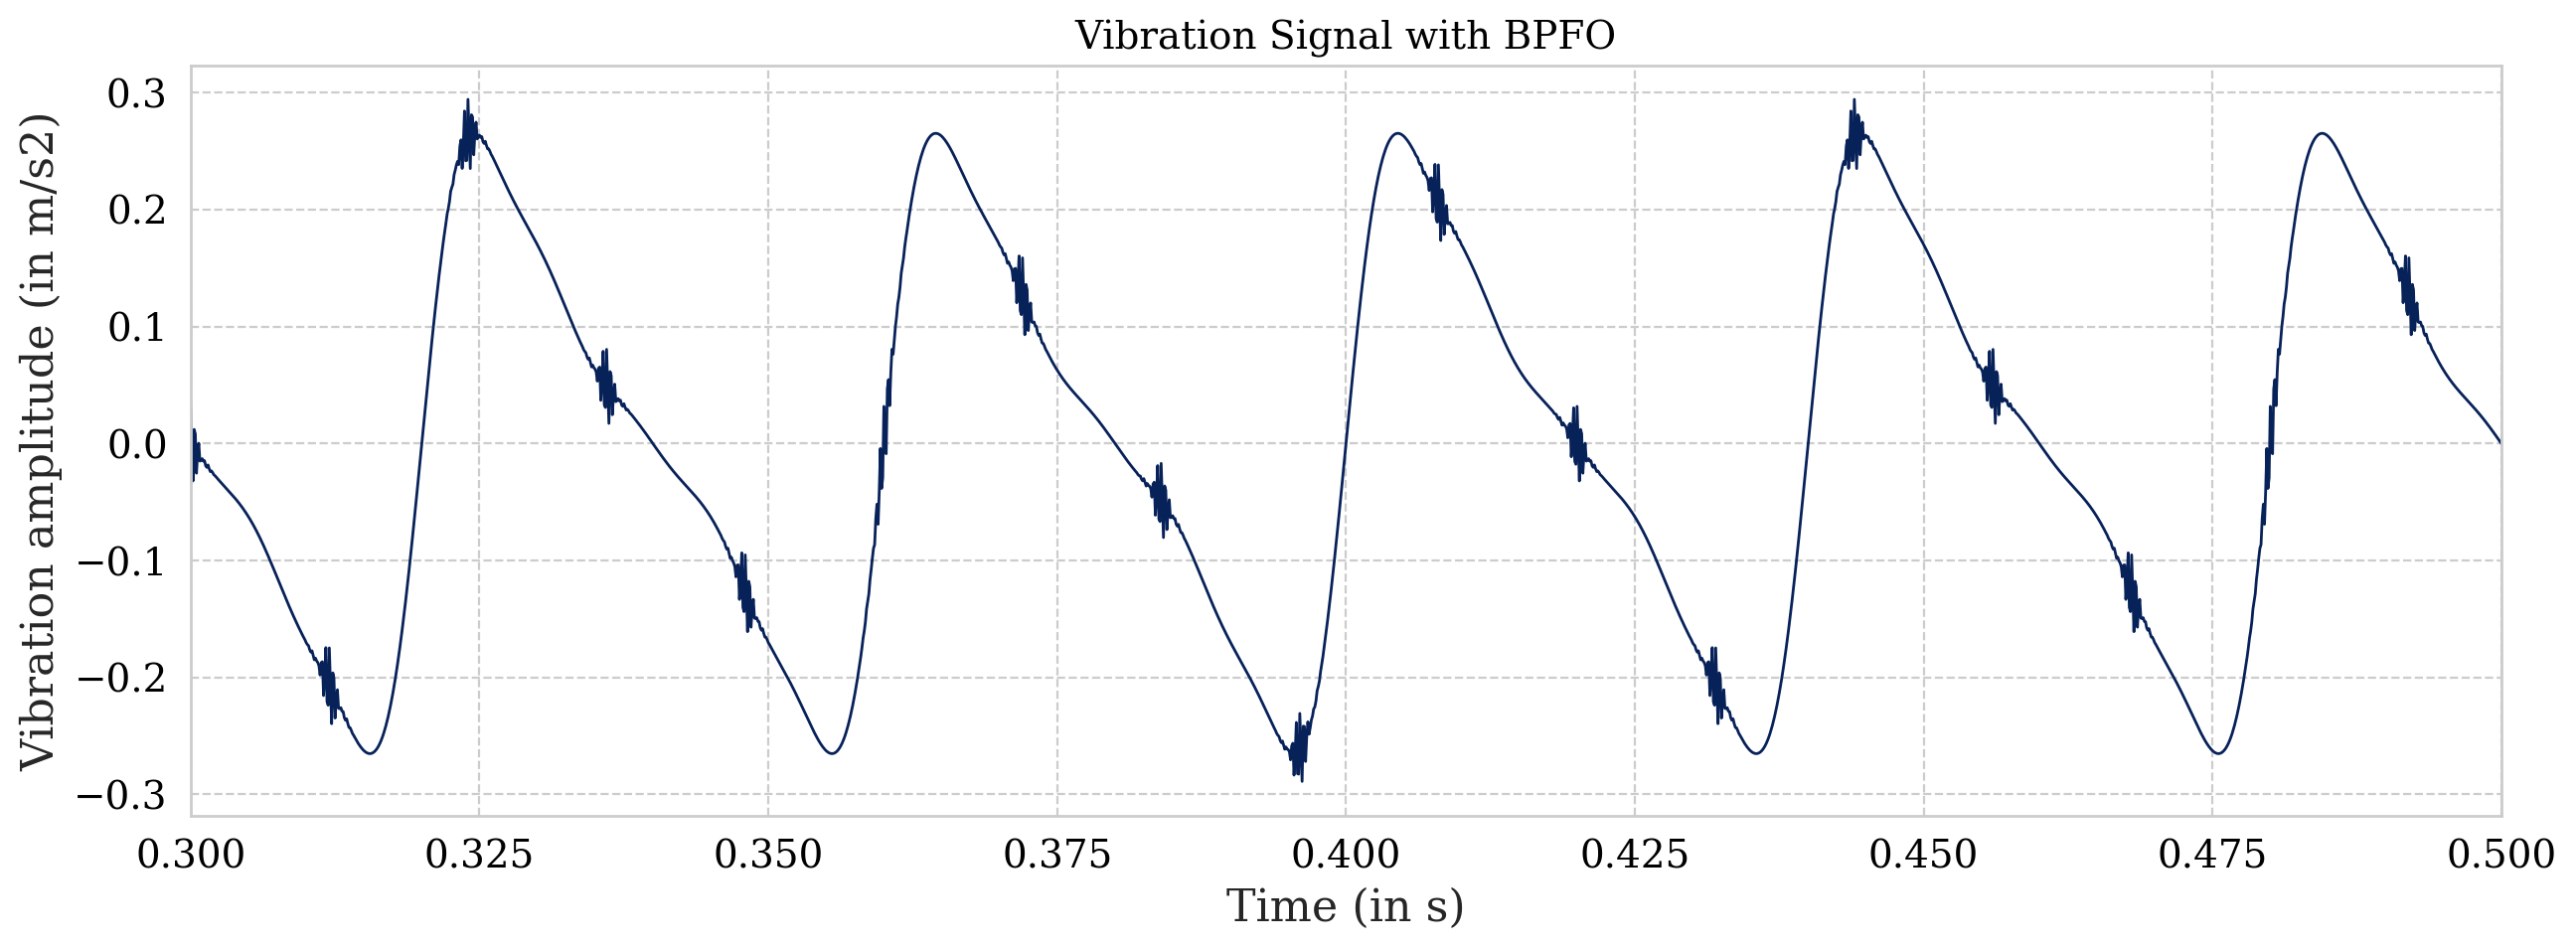

In [31]:
file_name = f'{folder_path}bpfo_signal'
title = 'Vibration Signal with BPFO'
plotting_methods.plot_signal(t, bpfo_fault, x_min=0.3, x_max=0.5, linewidth=1, name=title, save_path=file_name)


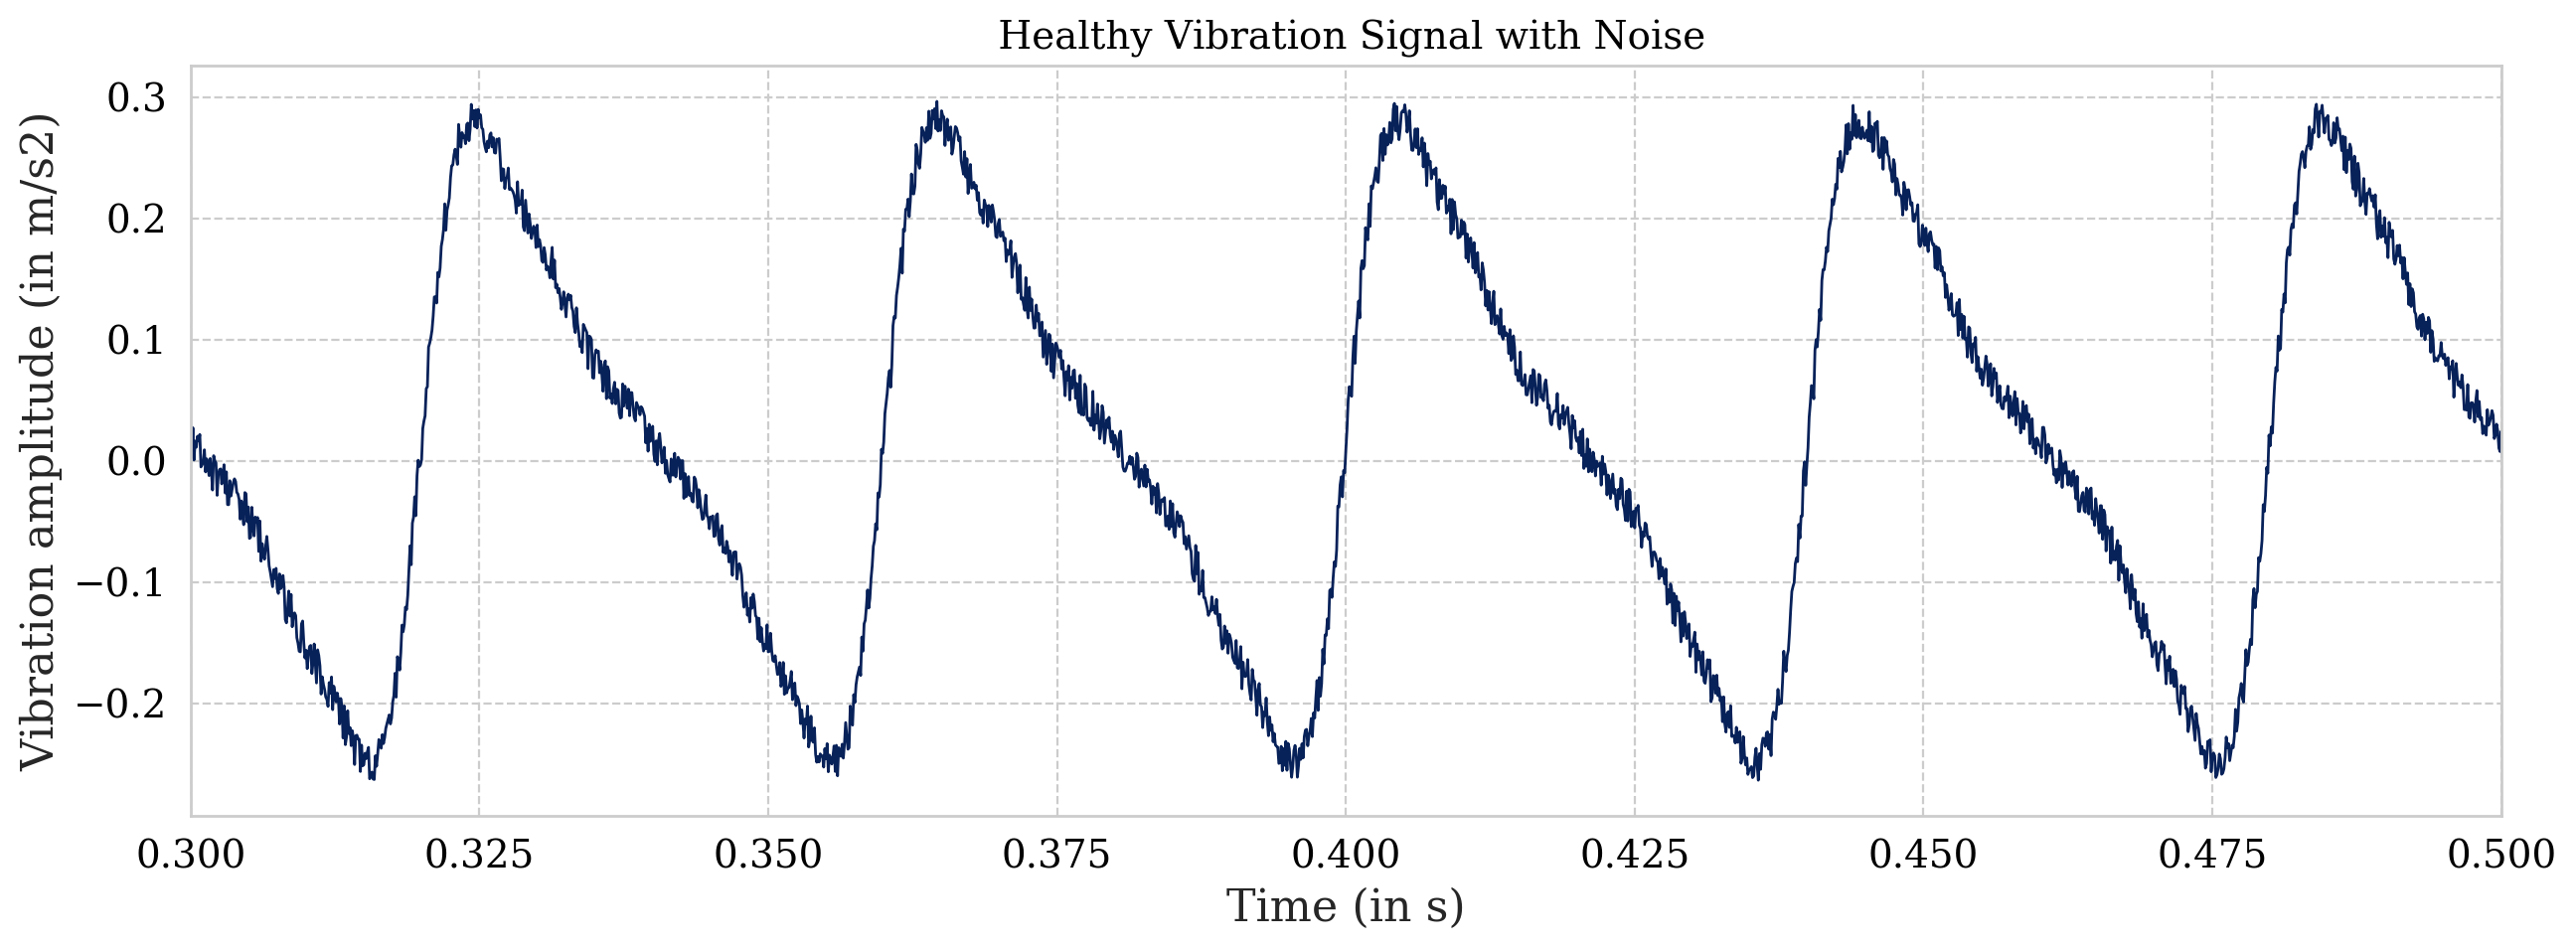

In [32]:
file_name = f'{folder_path}healty_with_noise'
title = ' Healthy Vibration Signal with Noise'
plotting_methods.plot_signal(t, healtyh_data_noise, x_min=0.3, x_max=0.5, linewidth=1, name=title, save_path=file_name)


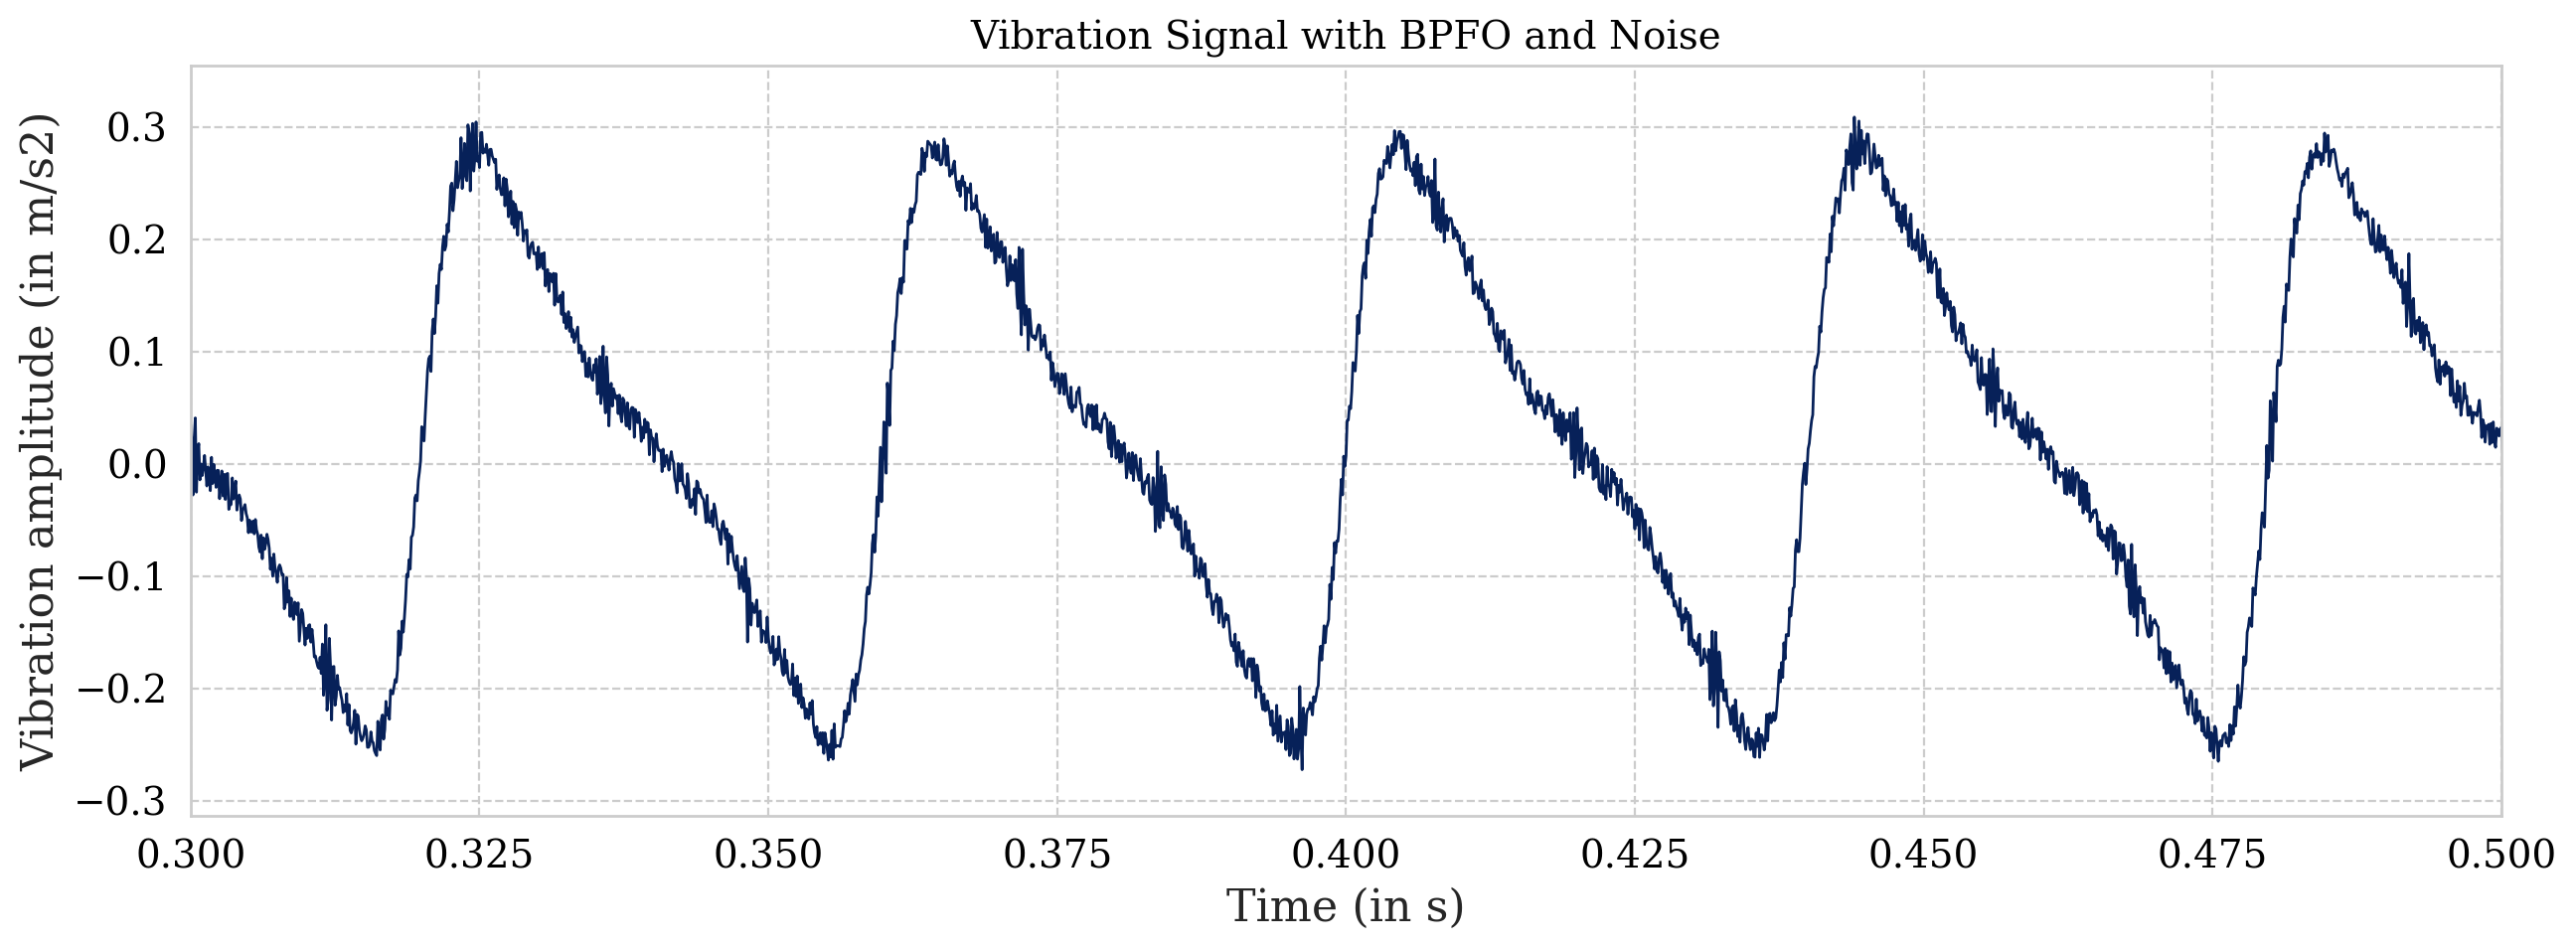

In [33]:
file_name = f'{folder_path}bpfo_with_noise'
title = 'Vibration Signal with BPFO and Noise'
plotting_methods.plot_signal(t, bpfo_fault_noise, x_min=0.3, x_max=0.5, linewidth=1, name=title, save_path=file_name)


### Signal with and without noise

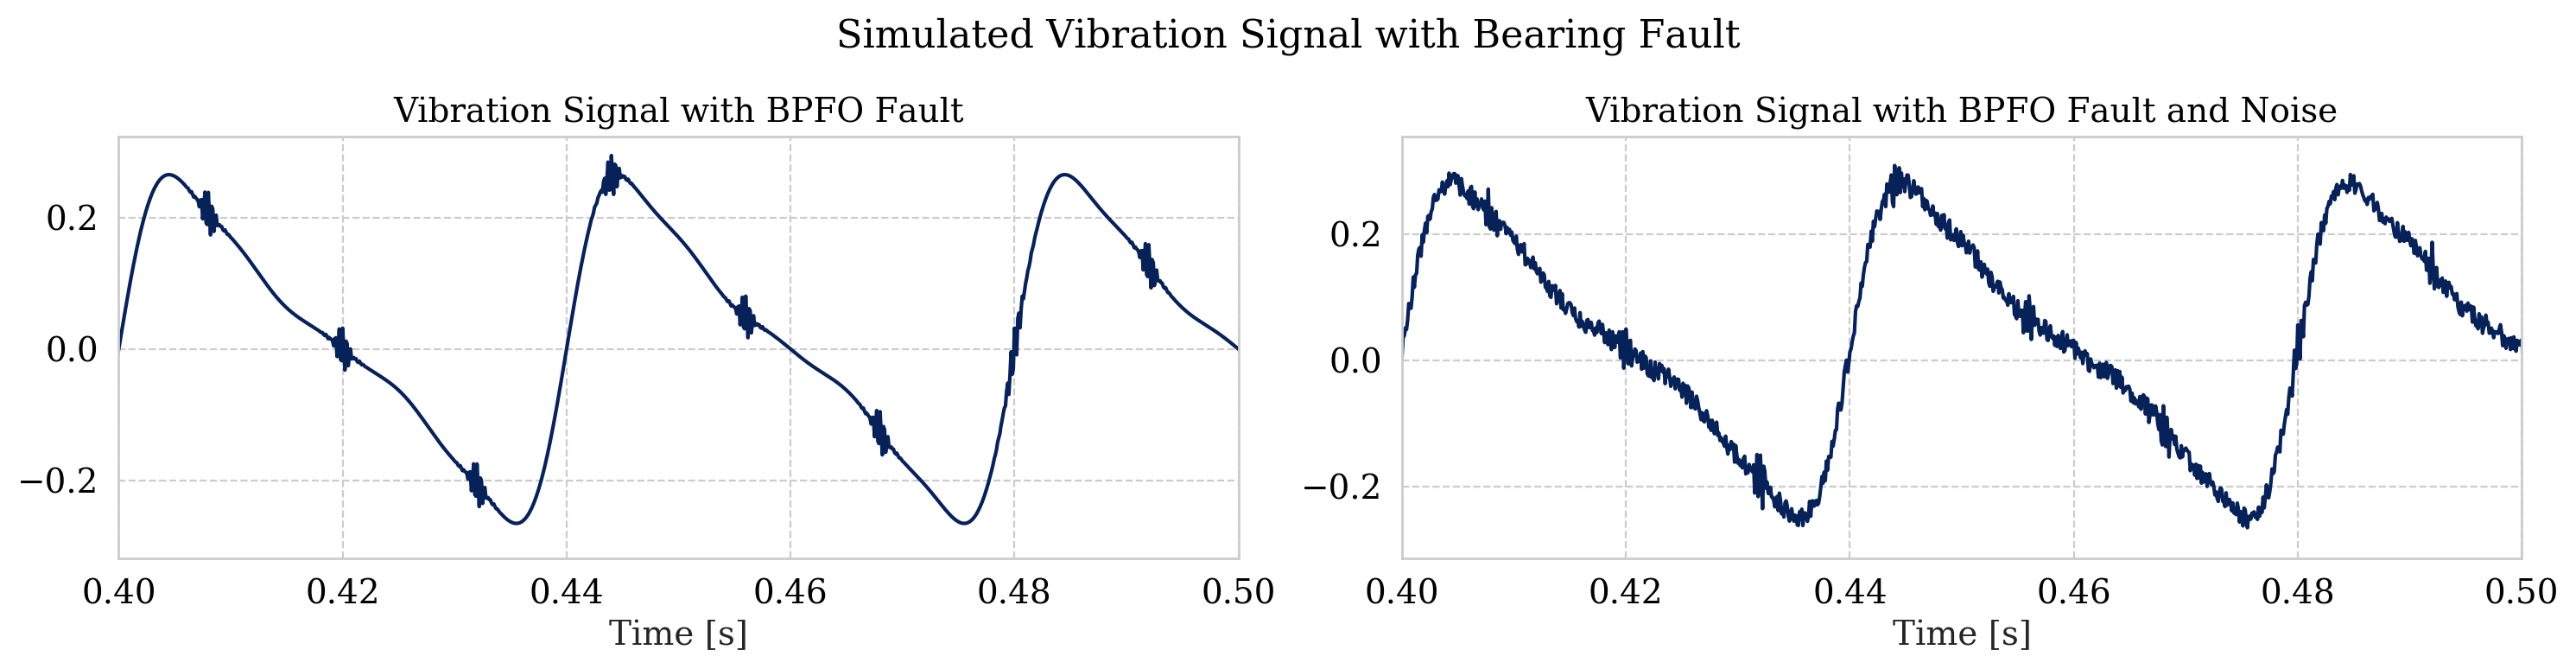

In [34]:
fig, ax = plt.subplots(1, 2,figsize=(15,3.5))
heading = 'Simulated Vibration Signal with Bearing Fault'
my_suptitle = fig.suptitle(heading,fontsize=16, y=1.09)

# Row 1
ax[0].plot(t, bpfo_fault)
ax[0].set_title(f"Vibration Signal with BPFO Fault")
ax[0].set_xlabel("Time [s]")
ax[0].set_xlim(0.4, 0.5)

ax[1].plot(t, bpfo_fault_noise)
ax[1].set_xlabel("Time [s]")
ax[1].set_title(f"Vibration Signal with BPFO Fault and Noise")
ax[1].set_xlim(0.4, 0.5)

plt.tight_layout()
plt.savefig(f'{folder_path}envelope_dummy_signal.png', dpi=300, bbox_extra_artists=[my_suptitle], bbox_inches='tight')
plt.show()

In [35]:
# Envelope signal of healty signal
lowcut = 1000
high_passed = filters.butter_hp_filter(healtyh_data_noise, lowcut, fs, order=5)
highut_lp = 2000
rectified = abs(high_passed)**2
healthy_envelope = filters.butter_lp_filter(rectified, highut_lp, fs, order=5)

file_name = f'{folder_path}envelope_fft_healthy'
title = 'Healthy Vibration Signal'
_,_ = plotting_methods.plot_fft(t, healthy_envelope, x_max=400, y_max=0.00005, name=title, save_path=file_name)



## Envelope signal of bpfo fault

In [36]:
lowcut = 1000
high_passed = filters.butter_hp_filter(bpfo_fault_noise, lowcut, fs, order=5)

highut_lp = 1000
rectified = abs(high_passed)#**2
bpfo_envelope = filters.butter_lp_filter(rectified, highut_lp, fs, order=5)


In [37]:
# RESAMPLE ENVELOPE SIGNAL TO ORDER

# Create peak_array
peak_array = np.zeros(len(t))
index = int(round(fs/f0))
peak_array[0:-1:index] = 1
peak_array = peak_array*t

zero_indexes = np.argwhere(peak_array==0)
peak_array = np.delete(peak_array, zero_indexes)
peak_array = np.insert(peak_array, 0, 0)

# Resample signal
x_round, resampled_y, _ = resample_signals.do_cubic_resampling(t, bpfo_envelope, peak_array, number_of_resample_points=800)


In [38]:
# Plotting
fft_ori, time_ori = plotting_methods.plot_fft(t, bpfo_fault_noise, x_max=400, name='BPFO Original')
fft_hp, time_hp = plotting_methods.plot_fft(t, high_passed, name='BPFO High Pass Filtered')
fft_rec, time_rec = plotting_methods.plot_fft(t, rectified, name='BPFO High Pass and Rectified')

file_name = f'{folder_path}envelope_fft_bpfo'
title = 'Envelope Spectrum of Vibration Signal with BPFO'
fft_envelope, time_envelope = plotting_methods.plot_fft(t, bpfo_envelope, x_max=400, name=title)#, y_max=0.00005)

title = 'Envelope Order Spectrum of Vibration Signal with BPFO'
fft_eoa, time_eoa = plotting_methods.plot_fft(x_round, resampled_y, x_max=16, name=title)#, y_max=0.00005
#plotting_methods.plot_signal(x_round, resampled_y, x_min=0.3, x_max=0.5, linewidth=1)


## Make one plot

In [40]:
peak_array

array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
       0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
       0.88, 0.92, 0.96])

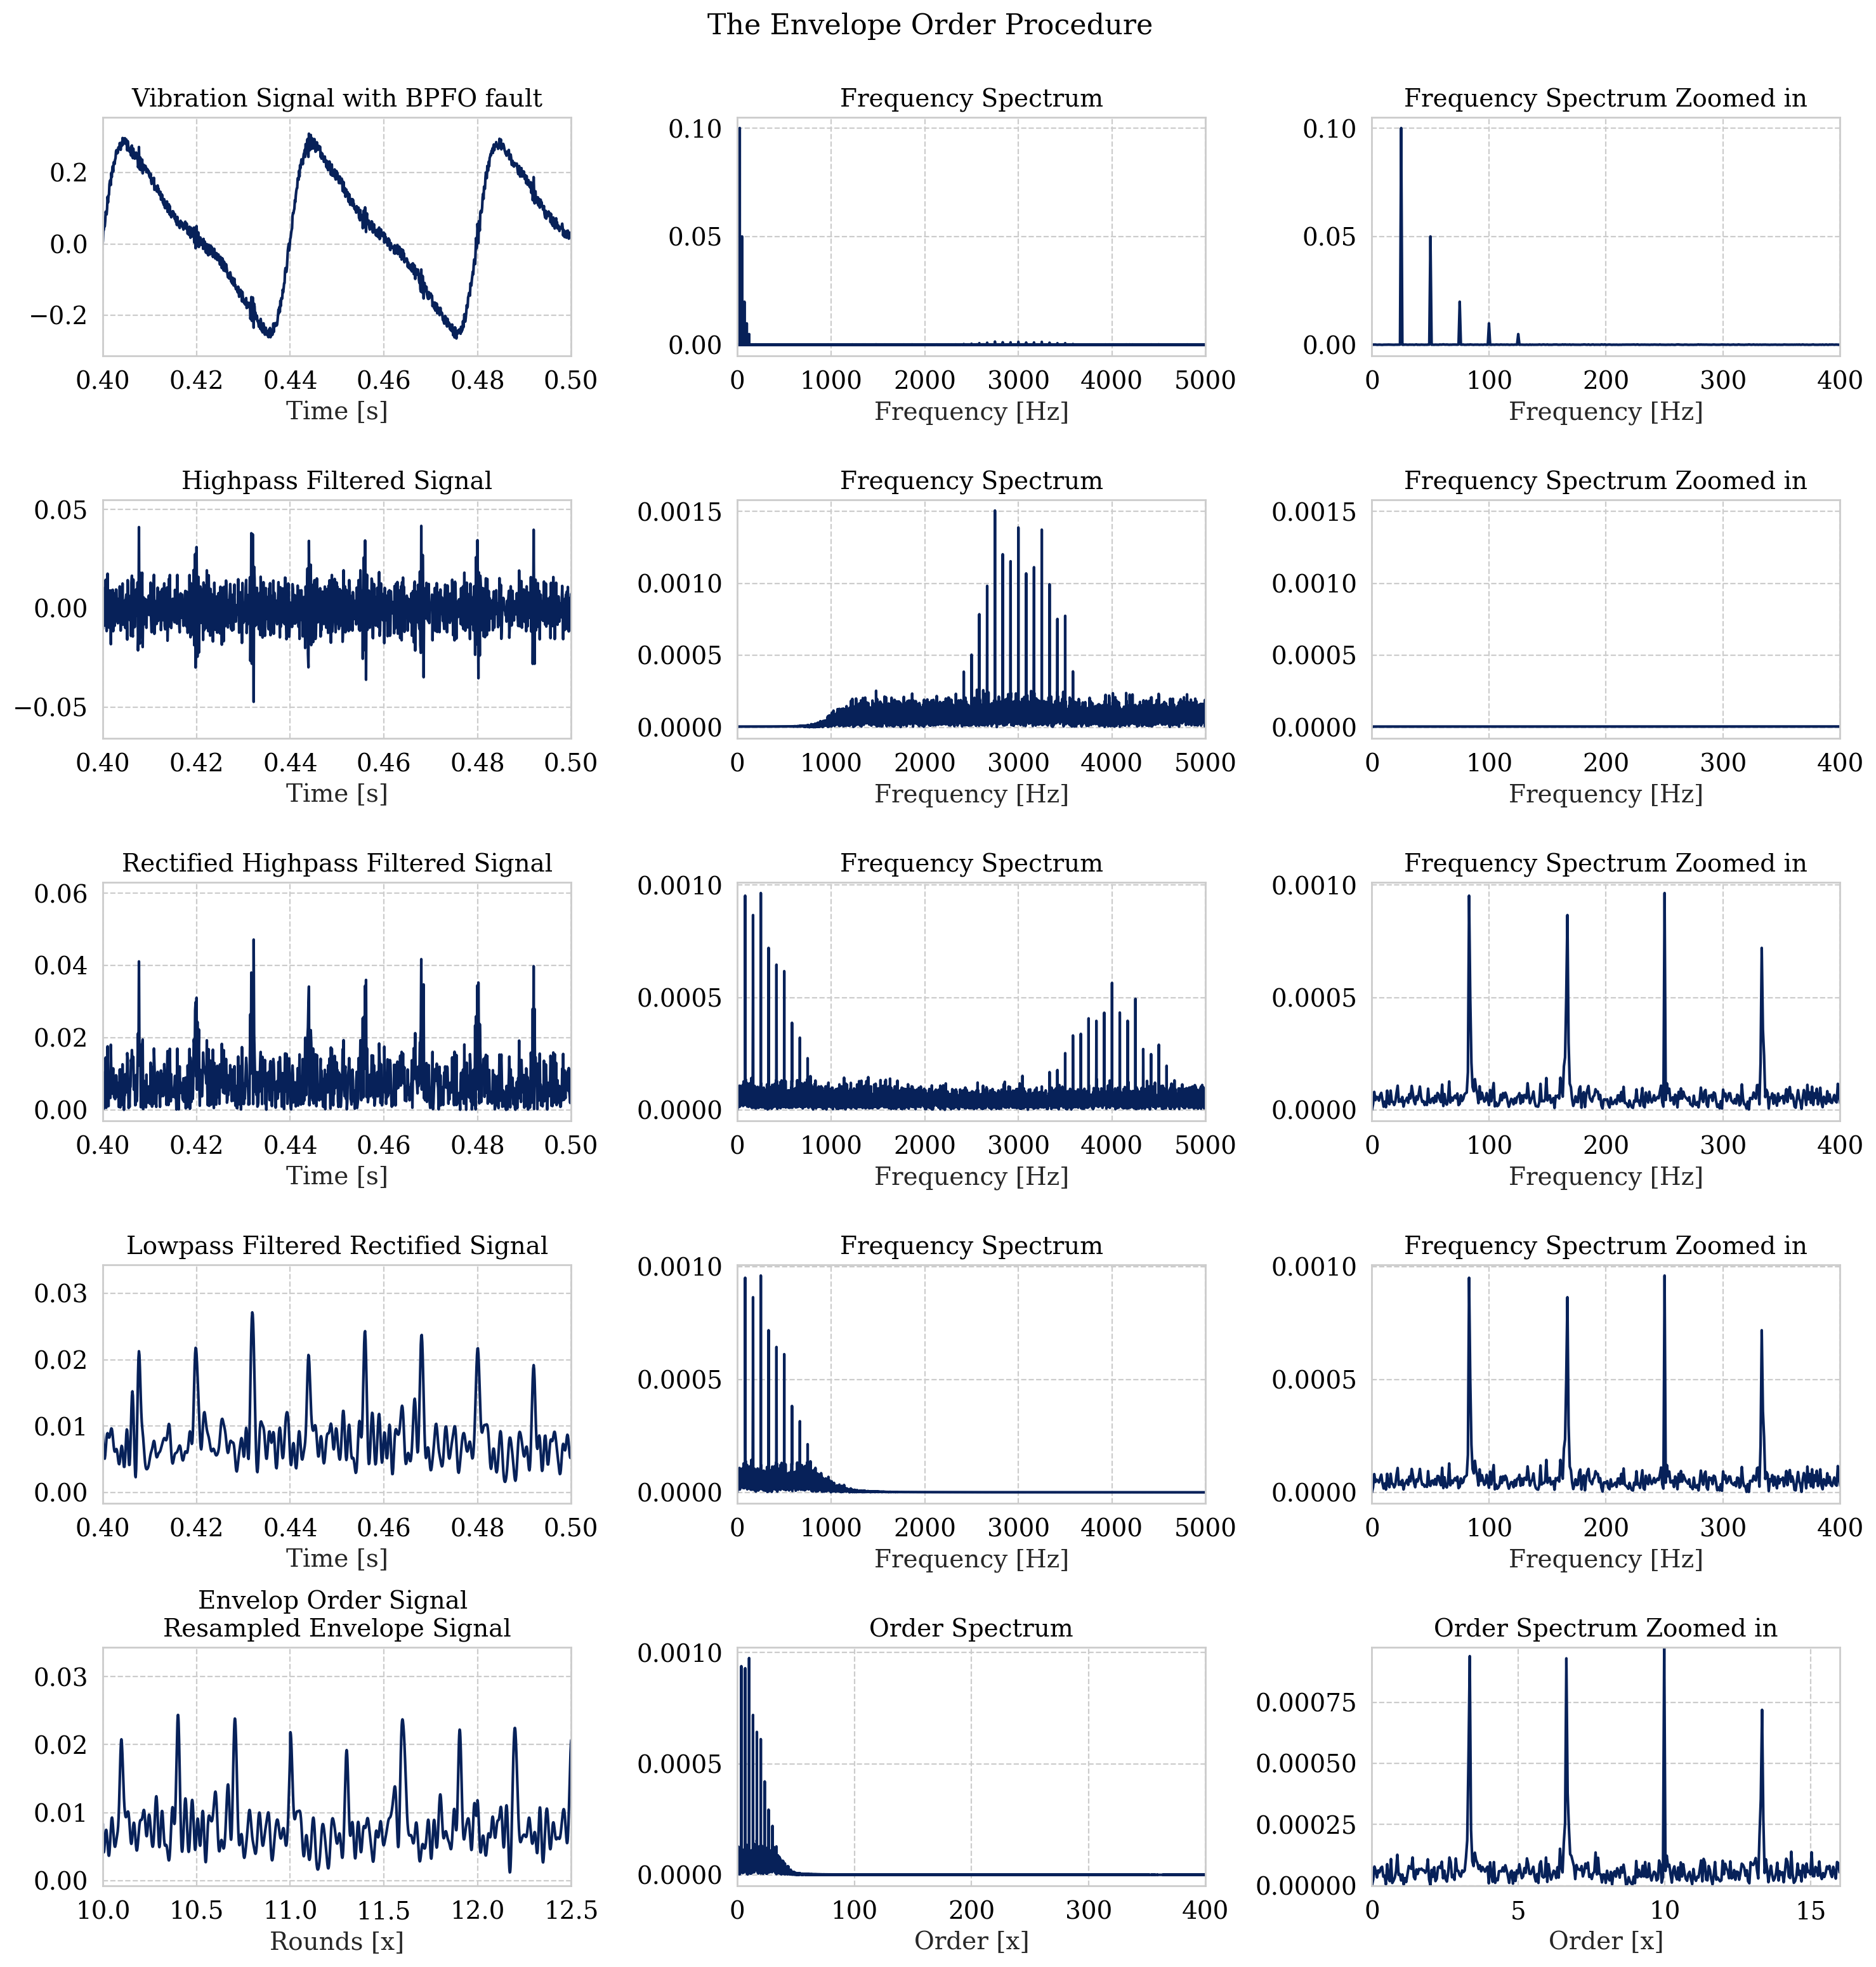

In [41]:
rows = 5
cols = 3

fig, ax = plt.subplots(rows, cols,figsize=(15,15))
heading = 'The Envelope Order Procedure'
my_suptitle = fig.suptitle(heading,fontsize=16, y=1.03)

# Row 1
ax[0,0].plot(t, bpfo_fault_noise)
ax[0,0].set_title(f"Vibration Signal with BPFO fault")
ax[0,0].set_xlabel("Time [s]")
ax[0,0].set_xlim(0.4, 0.5)

ax[0,1].plot(time_ori, plotable_fft(fft_ori))
ax[0,1].set_xlabel("Frequency [Hz]")
ax[0,1].set_title(f"Frequency Spectrum")
ax[0,1].set_xlim(0, 5000)

ax[0,2].plot(time_ori, plotable_fft(fft_ori))
ax[0,2].set_xlabel("Frequency [Hz]")
ax[0,2].set_title(f"Frequency Spectrum Zoomed in")
ax[0,2].set_xlim(0, 400)


# Row 2
ax[1,0].plot(t, high_passed)
ax[1,0].set_xlabel("Time [s]")
ax[1,0].set_title(f'Highpass Filtered Signal')
ax[1,0].set_xlim(0.4, 0.5)

ax[1,1].plot(time_hp, plotable_fft(fft_hp))
ax[1,1].set_xlabel("Frequency [Hz]")
ax[1,1].set_title(f"Frequency Spectrum")
ax[1,1].set_xlim(0, 5000)

ax[1,2].plot(time_hp, plotable_fft(fft_hp))
ax[1,2].set_xlabel("Frequency [Hz]")
ax[1,2].set_title(f"Frequency Spectrum Zoomed in")
ax[1,2].set_xlim(0, 400)


# Row 3
ax[2,0].plot(t, rectified)
ax[2,0].set_xlabel("Time [s]")
ax[2,0].set_title(f'Rectified Highpass Filtered Signal')
ax[2,0].set_xlim(0.4, 0.5)

ax[2,1].plot(time_rec, plotable_fft(fft_rec))
ax[2,1].set_xlabel("Frequency [Hz]")
ax[2,1].set_title(f"Frequency Spectrum")
ax[2,1].set_xlim(0, 5000)

ax[2,2].plot(time_rec, plotable_fft(fft_rec))
ax[2,2].set_xlabel("Frequency [Hz]")
ax[2,2].set_title(f"Frequency Spectrum Zoomed in")
ax[2,2].set_xlim(0, 400)


# Row 4
ax[3,0].plot(t, bpfo_envelope)
ax[3,0].set_xlabel("Time [s]")
ax[3,0].set_title(f'Lowpass Filtered Rectified Signal')
ax[3,0].set_xlim(0.4, 0.5)

ax[3,1].plot(time_envelope, plotable_fft(fft_envelope))
ax[3,1].set_xlabel("Frequency [Hz]")
ax[3,1].set_title(f"Frequency Spectrum")
ax[3,1].set_xlim(0, 5000)

ax[3,2].plot(time_envelope, plotable_fft(fft_envelope))
ax[3,2].set_xlabel("Frequency [Hz]")
ax[3,2].set_title(f"Frequency Spectrum Zoomed in")
ax[3,2].set_xlim(0, 400)


# Row 5
ax[4,0].plot(x_round, resampled_y)
ax[4,0].set_xlabel("Rounds [x]")
ax[4,0].set_title(f'Envelop Order Signal \nResampled Envelope Signal')
ax[4,0].set_xlim(10, 12.5)

ax[4,1].plot(time_eoa, plotable_fft(fft_eoa))
ax[4,1].set_xlabel("Order [x]")
ax[4,1].set_title(f"Order Spectrum")
ax[4,1].set_xlim(0, 400)

ax[4,2].plot(time_eoa, plotable_fft(fft_eoa))
ax[4,2].set_xlabel("Order [x]")
ax[4,2].set_title(f"Order Spectrum Zoomed in")
ax[4,2].set_xlim(0, 16)

plt.tight_layout()
plt.margins(0)
plt.savefig(f'{folder_path}envelope_steps.png', dpi=300, bbox_extra_artists=[my_suptitle], bbox_inches='tight')
plt.show()
